# Code for loading in the datasets and modelling

In [1]:
from loader import list_files, Files, Folders  #precalculate what we are loading in
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sys import getsizeof
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

{'wool': 14, 'jeans': 23, 'LacedMatt': 20, 'Gfoam': 22, 'bubble': 27, 'Efoam': 16, 'cotton': 21, 'Flat': 11, 'felt': 24, 'Ffoam': 26}


## Load in data

In [2]:
class loaded:
    def __init__(self,t=20):
        data = np.load("/its/home/drs25/Documents/data/Tactile Dataset/X_texture.npz") #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load("/its/home/drs25/Documents/data/Tactile Dataset/y_texture.npz") #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys={}
        self.files=['wool', 'LacedMatt', 'Gfoam', 'bubble', 'Efoam', 'cotton', 'Flat', 'felt', 'Ffoam']
        for i, name in enumerate(self.files):
            self.keys[i]=name
        self.keys={14: 'wool', 23: 'jeans', 20: 'LacedMatt', 22: 'Gfoam', 27: 'bubble', 16: 'Efoam', 21: 'cotton', 11: 'Flat', 24: 'felt', 26: 'Ffoam'}
        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:])).astype(np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined
data=loaded(t=4)
data.applySobel()
data.augment()

Dataset size: 4800 
Window size: 20 
Image: (110, 120)
Memory needed: 1.18 GB
Dataset size: 14400 
Window size: 4 
Image: (110, 120)
Memory needed: 0.71 GB


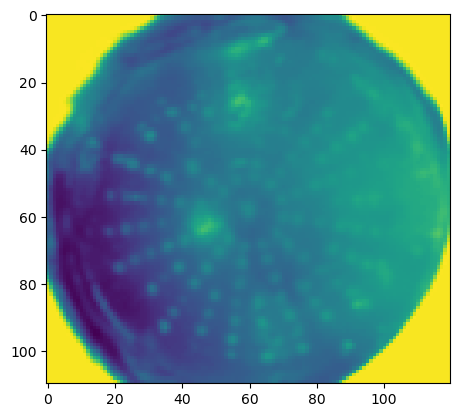

In [3]:
plt.imshow(data.X[0][0])
plt.show()

In [26]:
data.applySobel()

KeyError: 10

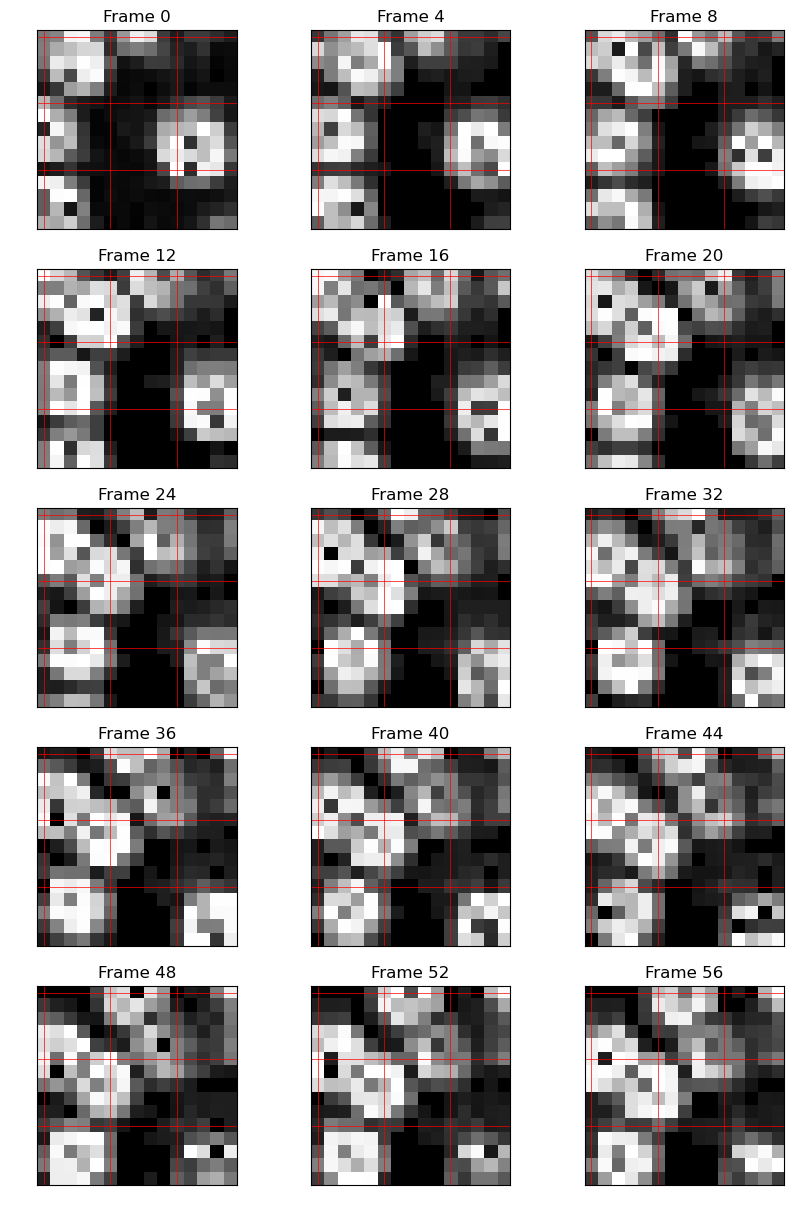

In [21]:
num_images = 15
texture=np.random.randint(0,100)
images = data.X[texture][0:15]

num_rows = 5
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15))

# Flatten the axes array for easy indexing
axes = axes.flatten()
ax = axes[0]
ax.set_title("Frame "+str(0))
ax.imshow(images[0][50:65,50:65], cmap='gray')
ax.set_xticks(np.arange(0, 15, 5))
# Set custom ticks for y-axis (every 10 units)
ax.set_yticks(np.arange(0, 15, 5))
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.5)
# Plot each image
imageA=images[0].astype(np.uint8)
kernel=np.array((9,9))
for i in range(1,num_images):
    imageB=images[i].astype(np.uint8)
    imageB[imageB<20]=0

    ax = axes[i]
    ax.imshow(imageB[50:65,50:65],cmap="gray")
    #ax.axis('off')
    ax.set_xticks(np.arange(0, 15, 5))
    # Set custom ticks for y-axis (every 10 units)
    ax.set_yticks(np.arange(0, 15, 5))
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.5)
    ax.set_title("Frame "+str(i*4))
    

# Remove any empty subplots
for i in range(num_images, num_rows*num_cols):
    fig.delaxes(axes[i])

plt.suptitle("Flow of "+str(data.keys[data.y[texture]]))
plt.tight_layout()
plt.savefig("/its/home/drs25/Pictures/TacTip real/rigData/centrepointMove.pdf")
plt.show()

## Look at spread of changes

In [30]:
#change=[np.zeros((len(data.X[0]))) for i in range(len(data.keys))]
change=np.zeros((len(data.X),41,20))
counter=[0 for i in range(len(data.keys))]
for i in range(len(data.X)):
    y=data.y[i]
    framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
    framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
    difference=np.abs(np.sum(framesA-framesB,axis=1))
    change[y][counter[y]]=difference
    counter[y]+=1

change=(np.array(change).T/np.array(counter)).T
change.shape

IndexError: list index out of range

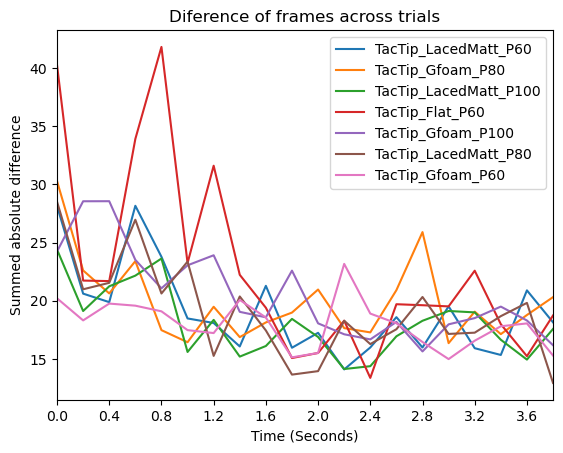

In [ ]:
av=np.average(change,axis=1)
for i in range(len(change)):
    plt.plot(av[i],label=data.keys[i])

plt.legend(loc="upper right")
plt.xticks([i for i in range(0,len(change[2]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[2]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.xlim([0,19])
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across trials")
plt.show()

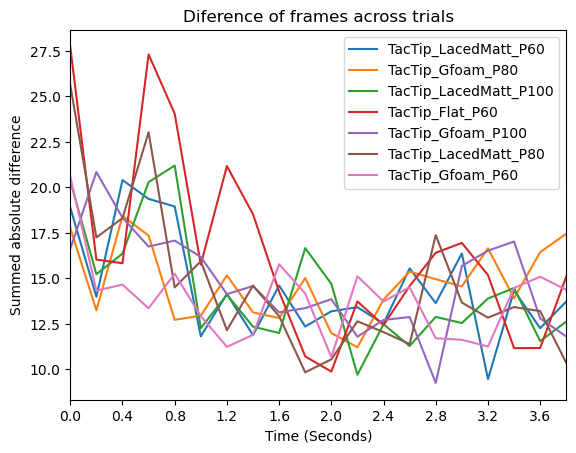

In [318]:
av=np.std(change,axis=1)
for i in range(len(change)):
    plt.plot(av[i],label=data.keys[i])

plt.legend(loc="upper right")
plt.xticks([i for i in range(0,len(change[2]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[2]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.xlim([0,19])
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across trials")
plt.show()

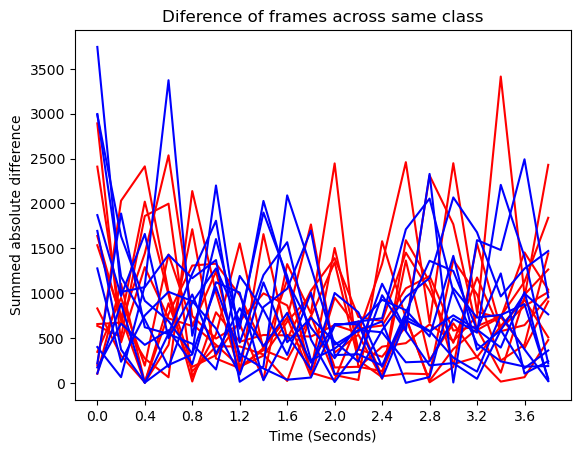

In [296]:
found=0
i=0
while found<10:
    y=data.y[i]
    if y==0:
        framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
        framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
        difference=np.abs(np.sum(framesA-framesB,axis=1))
        plt.plot(difference,c="r")
        found+=1
    i+=1
i=0
found=0
while found<10:
    y=data.y[i]
    if y==5:
        framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
        framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
        difference=np.abs(np.sum(framesA-framesB,axis=1))
        plt.plot(difference,c="b")
        found+=1
    i+=1

plt.xticks([i for i in range(0,len(change[0]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[0]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across same class")
plt.show()
    

# Machine learning
## Regression
### Ridge

In [4]:
reformed_X=data.AugmentedX.reshape(len(data.AugmentedX),4*110*120) 
n=int(len(data.AugmentedX)/3)
train_X=reformed_X[:n]
train_y=data.Augmentedy[:n]
test_X=reformed_X[n:n+2000]
test_y=data.Augmentedy[n:n+2000]
print(n,test_X.shape,train_X.shape)

4800 (2000, 52800) (4800, 52800)


In [5]:
alpha = 1.0  # Regularization parameter

# Define the Ridge regression model
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(train_X, train_y)
predictions = np.round(ridge_model.predict(test_X))
a=predictions-test_y
correct=len(a[a==0])
print("Accuracy",correct/len(a)*100,"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy 66.0 %
average loss 0.364


In [28]:
# t exp
alpha = 1.0 
t_ridge_train=[]
t_ridge_test=[]
for i in range(1,21,1):
    d=data.X[:,:i]
    reformed_X=d.reshape(4800,(i)*110*120) 
    train_X=reformed_X[:2000]
    train_y=data.y[0:2000]
    test_X=reformed_X[2000:2900]
    test_y=data.y[2000:2900]
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(train_X, train_y)
    predictionsX = ridge_model.predict(train_X)
    predictions = ridge_model.predict(test_X)
    a=(predictionsX-train_y).astype(np.int8)
    t_ridge_train.append(len(a[a==0])/len(a))
    a=(predictions-test_y).astype(np.int8)
    t_ridge_test.append(len(a[a==0])/len(a))
    del d
    del train_X
    del test_X
    del ridge_model
t_ridge_test=np.array(t_ridge_test)
t_ridge_train=np.array(t_ridge_train)
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_ridge_train",t_ridge_train)
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_ridge_test",t_ridge_test)

In [9]:
print("Accuracy:",(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions),"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy: 0.6411111111111111 %
average loss 0.35888888888888887


### Linear

In [16]:
reformed_X=data.X.reshape(4800,20*110*120)
train_X=reformed_X[:2000]
train_y=data.y[0:2000]
test_X=reformed_X[2000:2900]
test_y=data.y[2000:2900]
print(test_X.shape,train_X.shape)

(900, 264000) (2000, 264000)


In [8]:
linear_model = LinearRegression()

# Fit the model
linear_model.fit(train_X, train_y)
predictions = linear_model.predict(test_X)
print("Accuracy:",(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions),"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy: 0.7588888888888888 %
average loss 0.2411111111111111


In [23]:
# t exp
t_lin_train=[]
t_lin_test=[]
for i in range(1,21,1):
    d=data.X[:,0:i]
    reformed_X=d.reshape(4800,i*110*120) 
    train_X=reformed_X[:2000]
    train_y=data.y[0:2000]
    test_X=reformed_X[2000:2900]
    test_y=data.y[2000:2900]
    linear_model = LinearRegression()
    linear_model.fit(train_X, train_y)
    predictionsX = linear_model.predict(train_X)
    predictions = linear_model.predict(test_X)
    a=(predictionsX-train_y).astype(np.int8)
    t_lin_train.append(len(a[a==0])/len(a))
    a=(predictions-test_y).astype(np.int8)
    t_lin_test.append(len(a[a==0])/len(a))
    del d
    del train_X
    del test_X
    del linear_model
t_lin_test=np.array(t_lin_test)
t_lin_train=np.array(t_lin_train)
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_lin_train",t_lin_train)
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_lin_test",t_lin_test)

### Random forest

In [16]:
reformed_X=data.X.reshape(4800,4*110*120)
train_X=reformed_X[:2000]
train_y=data.y[0:2000]
test_X=reformed_X[2000:2900]
test_y=data.y[2000:2900]
print(test_X.shape,train_X.shape)

(900, 264000) (2000, 264000)


In [17]:
# Define the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)

# Fit the model
rf_model.fit(train_X, train_y)

predictions = rf_model.predict(test_X)
print("Accuracy:",(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions),"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy: 0.7411111111111112 %
average loss 0.2588888888888889


In [33]:
# t exp
t_for_train=[]
t_for_test=[]
for i in range(1,21,1):
    print(i)
    d=data.X[:,0:i]
    reformed_X=d.reshape(4800,i*110*120) 
    train_X=reformed_X[:2000]
    train_y=data.y[0:2000]
    test_X=reformed_X[2000:2900]
    test_y=data.y[2000:2900]
    rf_model = RandomForestRegressor(n_estimators=25, random_state=42)
    # Fit the model
    rf_model.fit(train_X, train_y)
    predictionsX = np.round(rf_model.predict(train_X))
    predictions = np.round(rf_model.predict(test_X))
    a=(predictionsX-train_y).astype(np.int8)
    t_for_train.append(len(a[a==0])/len(a))
    a=(predictions-test_y).astype(np.int8)
    t_for_test.append(len(a[a==0])/len(a))
    del d
    del train_X
    del test_X
    del rf_model
t_for_test=np.array(t_for_test)
t_for_train=np.array(t_for_train)
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_for_train",t_for_train)
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_for_test",t_for_test)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


### Visualising regression

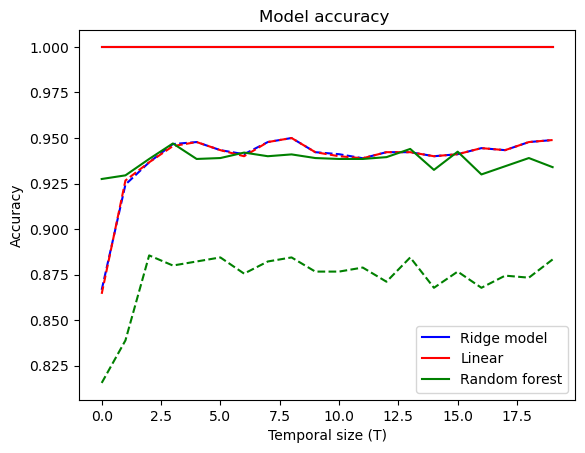

In [35]:
t_ridge_test=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_ridge_test.npy")
t_ridge_train=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_ridge_train.npy")
t_lin_test=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_lin_test.npy")
t_lin_train=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_lin_train.npy")
t_for_test=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_for_test.npy")
t_for_train=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_for_train.npy")
plt.plot(t_ridge_train,c="b",label="Ridge model")
plt.plot(t_ridge_test,"--",c="b")
plt.plot(t_lin_train,c="r",label="Linear")
plt.plot(t_lin_test,"--",c="r")
plt.plot(t_for_test,"--",c="g")
plt.plot(t_for_train,c="g",label="Random forest")
plt.legend(loc="lower right")
plt.xlabel("Temporal size (T)")
plt.ylabel("Accuracy")
plt.title("Model accuracy ")
plt.show()

In [7]:
n=int(len(data.AugmentedX)/4)
reformed_X=data.AugmentedX[0:n+2000,:].reshape(len(data.AugmentedX[0:n+2000,:]),4*110*120)
scaler = StandardScaler()
reformed_X = scaler.fit_transform(reformed_X)
n_components = 5
pca = PCA(n_components=n_components)
reformed_X = pca.fit_transform(reformed_X)
n=int(len(data.AugmentedX)/4)
train_X=reformed_X[:n]
train_y=data.Augmentedy[:n]
test_X=reformed_X[n:n+2000]
test_y=data.Augmentedy[n:n+2000]
print(test_X.shape,train_X.shape)
alpha = 1.0  # Regularization parameter
# Analyze the explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each component: {explained_variance}')
print(f'Total explained variance: {np.sum(explained_variance)}')

(2000, 5) (3600, 5)
Explained variance by each component: [0.32813857 0.31354005 0.03009325 0.02799186 0.02244109]
Total explained variance: 0.7222048193254523


In [5]:
n=int(len(data.AugmentedX)/4)
reformed_X=data.AugmentedX[0:n+2000,:].reshape(len(data.AugmentedX[0:n+2000,:]),4*110*120)
scaler = StandardScaler()
reformed_X = scaler.fit_transform(reformed_X)
n_components = 800
pca = PCA(n_components=n_components)
reformed_X = pca.fit_transform(reformed_X)
n=int(len(data.AugmentedX)/4)
train_X=reformed_X[:n]
train_y=data.Augmentedy[:n]
test_X=reformed_X[n:n+2000]
test_y=data.Augmentedy[n:n+2000]
print(test_X.shape,train_X.shape)
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each component: {explained_variance}')
print(f'Total explained variance: {np.sum(explained_variance)}')
alpha = 1.0  # Regularization parameter

#create best models
print("RF")
rf_model = RandomForestRegressor(n_estimators=25, random_state=42)
rf_model.fit(train_X, train_y)
predictionsA = np.round(rf_model.predict(test_X))
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsA_augmentedPCA",predictionsA)
del rf_model
print("LR")
linear_model = LinearRegression()
linear_model.fit(train_X, train_y)
predictionsB = np.round(linear_model.predict(test_X))
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsB_augmentedPCA",predictionsB)
del linear_model
print("RR")
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(train_X, train_y)
predictionsC = np.round(ridge_model.predict(test_X))
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsC_augmentedPCA",predictionsC)
del ridge_model

#predictions

: 

: 

In [3]:
predictionsA=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsA_augmentedPCA.npy")
predictionsB=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsB_augmentedPCA.npy")
predictionsC=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsC_augmentedPCA.npy")
trsy_y=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/test_y_augmentedPCA.npy")
a=predictionsA-test_y
correct=len(a[a==0])
print("Accuracy",correct/len(a))

a=predictionsB-test_y
correct=len(a[a==0])
print("Accuracy",correct/len(a))

a=predictionsC-test_y
correct=len(a[a==0])
print("Accuracy",correct/len(a))

NameError: name 'test_y' is not defined

[[ 80.  96.  90.  84.  53.  69.  23.  72.  99.]
 [ 56. 105.  87.  83.  92.  67.  65.  56. 125.]
 [ 56. 106.  87.  83.  91.  67.  65.  56. 123.]]
[[1334. 1334. 1334. 1334. 1334. 1334. 1334. 1334. 1334.]
 [1264. 1264. 1264. 1264. 1264. 1264. 1264. 1264. 1264.]
 [1266. 1266. 1266. 1266. 1266. 1266. 1266. 1266. 1266.]]


/tmp/ipykernel_65014/1824848251.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=90,fontsize=12)
/tmp/ipykernel_65014/1824848251.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=90,fontsize=12)


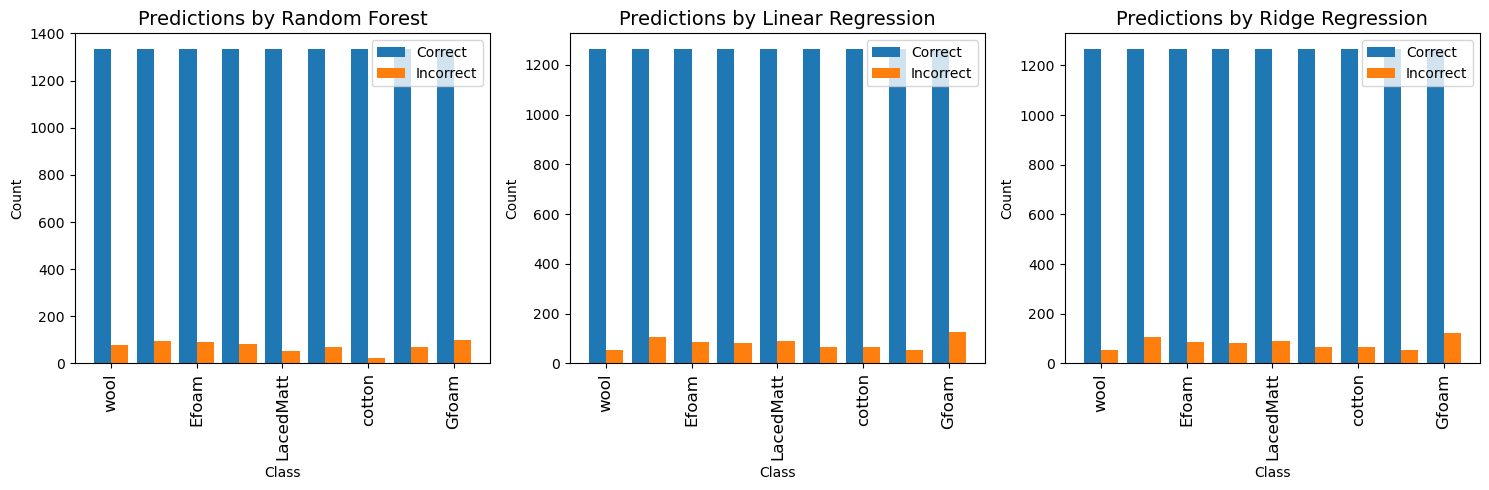

In [11]:
#show histogram
# Combine all predictions
predictions = [predictionsA, predictionsB, predictionsC]
model_names = ['Random Forest', 'Linear Regression', 'Ridge Regression']
num_models = len(predictions)
num_classes = len(np.unique(test_y))

# Prepare data for the histograms
correct_counts = np.zeros((num_models, num_classes))
incorrect_counts = np.zeros((num_models, num_classes))

for i, preds in enumerate(predictions):
    for k in range(len(test_y)):
        for j,cls in enumerate(np.unique(test_y)):
            if test_y[k]==preds[k]:
                correct_counts[i, j] +=1
            elif test_y[k]!= preds[k] and test_y[k]==cls: #data.files.index(data.keys[test_y[k]])
                incorrect_counts[i, j] +=1

print(incorrect_counts)
print(correct_counts)
# Plotting
fig, axes = plt.subplots(1, num_models, figsize=(15, 5))

for i in range(num_models):
    ax = axes[i] if num_models > 1 else axes
    width = 0.4
    indices = np.arange(num_classes)
    
    ax.bar(indices - width/2, correct_counts[i], width, label='Correct')
    ax.bar(indices + width/2, incorrect_counts[i], width, label='Incorrect')
    
    ax.set_title(f'Predictions by {model_names[i]}',fontsize=14)
    ax.set_xlabel('Class',fontsize=10)
    ax.set_ylabel('Count',fontsize=10)
    ax.set_xticklabels([data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=90,fontsize=12)
    ax.set_xticklabels([data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=90,fontsize=12)
    ax.legend()

plt.tight_layout()
plt.show()

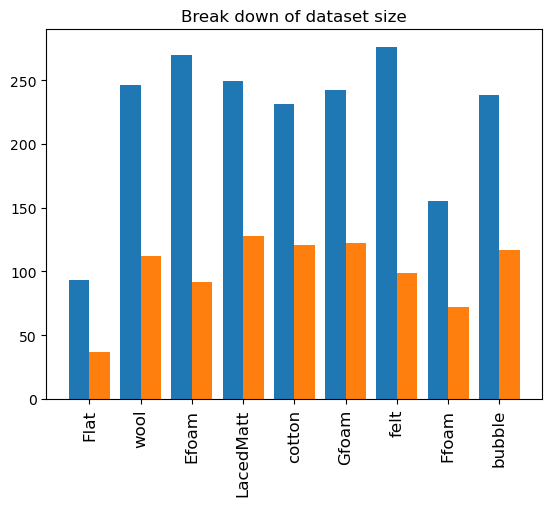

In [10]:
#show distribution of data classes

num_classes = len(np.unique(train_y))
un=np.unique(test_y)
width = 0.4
indices = np.arange(num_classes)
num_in_classes=np.zeros((num_classes,))
num_in_test=np.zeros((num_classes,))
for i in range(num_classes):
    num_in_classes[i]=len(train_y[train_y==un[i]])
    num_in_test[i]=len(test_y[test_y==un[i]])
plt.bar(indices - width/2, num_in_classes, width, label='Correct')
plt.bar(indices + width/2, num_in_test, width, label='Incorrect')

plt.xticks([j for j in range(num_classes)],[data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=90,fontsize=12)
plt.title("Break down of dataset size")
plt.show()

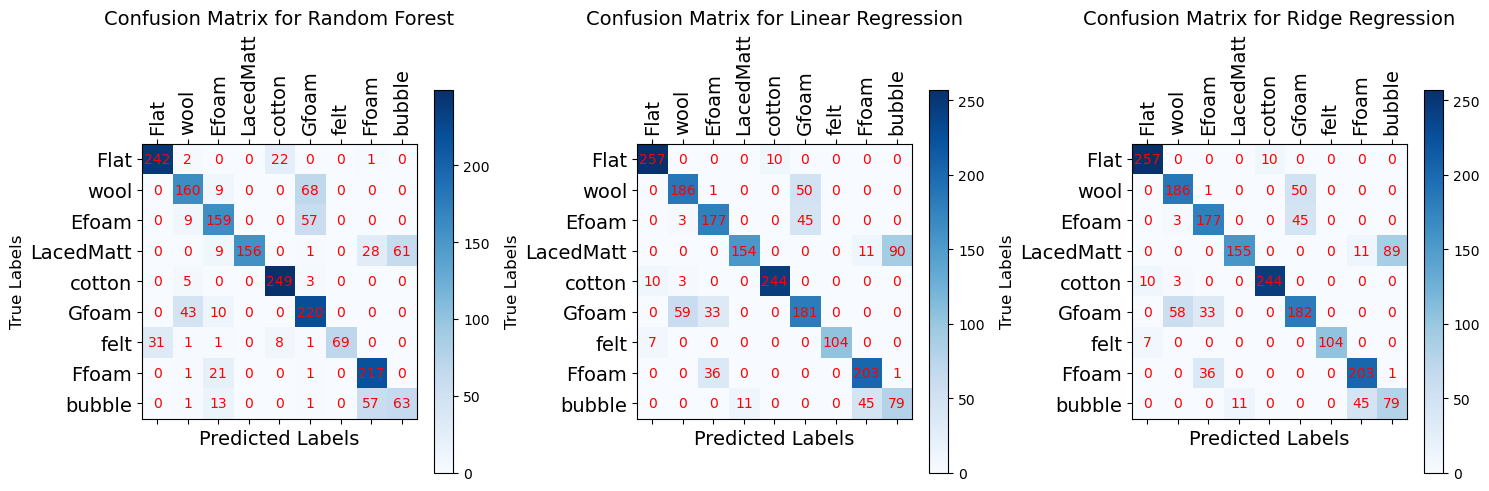

In [12]:
def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(test_y)
    for t, p in zip(true_labels, pred_labels):
        if p not in un: p=data.files.index(data.keys[find_nearest(un,p)])
        else: p=data.files.index(data.keys[int(p)])
        matrix[data.files.index(data.keys[t]), p] += 1
    return matrix
def find_nearest(array, value):
    # Calculate the absolute differences
    differences = np.abs(array - value)
    # Find the index of the minimum difference
    index_of_min = np.argmin(differences)
    # Return the value at that index in the original array
    return array[index_of_min]
# Combine all predictions
predictions = [predictionsA, predictionsB, predictionsC]
model_names = ['Random Forest', 'Linear Regression', 'Ridge Regression']

# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(15, 5))

for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(test_y, preds, num_classes=len(np.unique(test_y)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{value}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.show()